# Time Line
### 3.16
* ricardo: train model on whole dataset, add distance
* yiqi: add distance, use randomforest, format current notebook

## Target- urgent withdrawn by nurse(within 24hr)
* shift_applications status == 'cancelled' + shift_application prevStatus == 'confirmed'


### IDs -> only look at shifts application, leave each shifts after
* shift_applications id
* shift_applications user_id
* shift_applications shift_id


### Numeric Field
* shifts rate
* shifts net_pay: rate - nursedash profit
* shift_applications distance
* shift break time
* user withdrawn times: 
    Problem: 
        1. We don't know in reality that you will withdraw your previous one.
        2. cannot be used to predict new user
* user applied times:
* <b>prev SA/CW rate<b/>


## Time
### shift, shift app time
* S_Create (shift created) => SA_Create (application created) => CWTime (comfim withdrawn) => Start_Time (shift start)
* S_Create: shift create time
* SA_Create: shift application create time
* CWTime: shift withdrawn time, whole confirmed withdrawn population (include within 24hr and > 24hr)
* Start_Time: shift start time
##### calculated field, graph in hours
* <b>S_Create2SA_Create<b/>: shift application create time - shift create time
* <b>S_Create2Start_Time<b/>: shift start time - shift create time
        1. has negative values. delete maybe?
* <b>SA_Create2Start_Time<b/>: shift start time - shift application create time
        1. has negative values. delete maybe?

### User
* user approvedAt:
* user createdAt:
#### Calculated field
* U_Create2U_approved: User approve time - User create time
* <b>U_Create2now<b/>: now - User create time, in months(seconds/2629746)
* <b>U_Approve2now<b/>: now - User approve time


### Categorical
* shifts role: position name + type
* facilities name = facilities short_name
* facilities areaId = facilities areaName
* withdrawnInfo_key, withdrawnInfo_value
* facilities segmentName: Senior Living = 1, Healthcare = 0
* Users enableNotifications:
* Users emailNotifications:
* Users appNotifications:
* Users allowedNotifications:


### ?
* facilities allowedQualification
* facilities createdAt
* facilities rates
* nurse shift withdrawn by admin, when policy start, how many withdrawn by admin
* shifts = unit
* role
* users updateAt ?
* users relationToFacility

# Data Cleaning

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('main.csv').drop(columns = ['Unnamed: 0'])
df.columns

Index(['id', 'user_id', 'shift_id', 'status', 'createdAt',
       'hasNurseCheckEvent', 'hasBreakTime', 'prevStatus', 'distance', 'id.1',
       'facility_id', 'description', 'start_time', 'assigned_nurse_id', 'rate',
       'net_pay', 'unit', 'type', 'createdAt.1', 'qualifications', 'breakTime',
       'prevStatus.1', 'id.2', 'name', 'short_name', 'createdAt.2', 'rates',
       'S_Create', 'SA_Create', 'S_create2SA_Create', 'Start_Time',
       'SA_Create2Start_Time', 'S_Create2Start_Time', 'CW_Time',
       'CW_Time2Start_Time', 'SA_Create2CW_Time', 'S_Create2CW_Time',
       'allowedQualifications', 'areaId', 'areaName', 'segmentName',
       'U_create2now', 'U_approve2now', 'U_create2U_approve',
       'withdrawnInfo_key', 'withdrawnInfo_value', 'tar'],
      dtype='object')

In [2]:
df.shape

(169654, 47)

In [3]:
#df['tar'] = df.apply(lambda x: 1 if x['status'] == 'withdrawn' and x['prevStatus'] == 'confirmed' and x['withdrawnInfo_value'] == 'nurse' and df['CW_Time2Start_Time'] > -24 else 0, axis =1)

In [4]:
def CW_by_nurse(row):
    if row['status']=='withdrawn' and row['prevStatus'] == 'confirmed':
        if row['withdrawnInfo_value'] == 'nurse':
            if row['CW_Time2Start_Time'] < 0 and row['CW_Time2Start_Time'] >= -24:
                return 1
            else:
                return 0
        else:
            return 0
    else:
        return 0
    
df['target'] = df.apply (lambda row: CW_by_nurse(row), axis=1)

In [5]:
df['target'].value_counts()

0    165284
1      4370
Name: target, dtype: int64

In [6]:
# There are some negative numbers in this column. Not very much. 
# I think we need to delete these data entries since it make it impossible to nurse to apply on time.

df = df[(df["S_Create2Start_Time"]>0) & (df["SA_Create2Start_Time"]>0)]

In [7]:
# df2 is a sorted version of df1, data is exactly the same
df1 = df.set_index(['user_id','id'])
df2 = df1.sort_index()
df2 = df2.reset_index()

In [8]:
def count_prev_SA(df):
    count_prev_SA = []
    id_number = 0
    count = 0
    user_id = list(df2['user_id'])
    for i in user_id:
        if id_number == i:
            count += 1
            count_prev_SA.append(count)
            id_number = i
        else:
            count = 0
            count_prev_SA.append(count)
            id_number = i
    return count_prev_SA

        
df2['count_prev_SA'] = count_prev_SA(df2)

In [9]:
def count_prev_CW(df):
    count_prev_CW = []
    id_number = 0
    count = 0
    user_id = list(df2['user_id'])
    urgent_CW = list(df2['target'])
    for i,v in enumerate(user_id):
        if id_number == v:
            count_prev_CW.append(count)
            if urgent_CW[i] == 1:
                count += 1
            id_number = v
        else:
            count = 0
            count_prev_CW.append(count)
            if urgent_CW[i] == 1:
                count += 1
            id_number = v
    return count_prev_CW

        
df2['count_prev_CW'] = count_prev_CW(df2)

In [10]:
df2['prev_CW/SA_rate'] = df2['count_prev_CW']/df2['count_prev_SA']
df2['prev_CW/SA_rate'].fillna(0,inplace=True)

In [11]:
#df2.head(5)

In [12]:
#df2['prev_CW/SA_rate']

In [13]:
# create type dummy: RN = 1, LVN + LPN = 2, rest = 0
def create_type_dummy(row):
    if row['type']=='RN':
        return 2
    elif row['type'] == 'LVN' or row['type'] == 'LPN':
        return 1
    else:
        return 0
    
df2['type_d'] = df2.apply(lambda row: create_type_dummy(row), axis=1)

In [14]:
# create type dummy: Senior Living, Healthcare
def create_segmentName_dummy(row):
    if row['segmentName']=='Senior Living':
        return 1
    else:
        return 0
    
df2['segmentName_d'] = df2.apply(lambda row: create_segmentName_dummy(row), axis=1)

In [ ]:
#df['segmentName']

In [16]:
df2 = df2[['prev_CW/SA_rate','S_create2SA_Create','S_Create2Start_Time','SA_Create2Start_Time','U_create2now',
          'U_approve2now', 'type_d','segmentName_d','net_pay','distance','target']]
df2.to_csv('model_data.csv')

# Logistic Regression 1  

# import 'model_data.csv' as df2

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
mm_train_scaled = scaler.fit_transform(df2[['prev_CW/SA_rate','S_create2SA_Create','S_Create2Start_Time',
                                            'SA_Create2Start_Time','U_create2now','U_approve2now','net_pay']])

In [18]:
df3 = df2[['prev_CW/SA_rate','S_create2SA_Create','S_Create2Start_Time','SA_Create2Start_Time','U_create2now',
          'U_approve2now', 'type_d','segmentName_d','net_pay','target']]

In [19]:
# make nontar dataset length = target dataset
import random
df3_tar = df3[df3['target']==1].reset_index(drop=True)
df3_nontar = df3[df3['target']==0].reset_index(drop=True)

number_of_tar = df3_tar.shape[0]
random_indices = random.sample(range(len(df3_nontar)), int(number_of_tar))
df3_nontar = df3_nontar[df3_nontar.index.isin(random_indices)]
df4 = pd.concat([df3_tar, df3_nontar])

In [20]:
# df4.isna().sum()
df4.dropna(inplace=True)

In [21]:
def summary_coef(model_object):
    n_predictors = X.shape[1]
    model_coef = pd.DataFrame(model_object.coef_.reshape(1,n_predictors),columns = X.columns.values)
    model_coef['Intercept'] = model_object.intercept_
    return (model_coef.transpose())

In [22]:
from sklearn.model_selection import train_test_split

#Splitting the data into our partitions will return two dataframes, so we must prep like so:
testpart_size = .2
df_partition = df

df_nontestdata, df_testdata = train_test_split(df4, test_size = testpart_size, random_state = 1)

In [23]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

X_train = df_nontestdata.drop(columns = ['target'])
y_train = df_nontestdata['target']
X_test = df_testdata.drop(columns = ['target'])
y_test = df_testdata['target']

In [24]:
logit = LogisticRegressionCV(scoring='roc_auc',max_iter=100000)
logit.fit(X_train,y_train)

LogisticRegressionCV(max_iter=100000, scoring='roc_auc')

In [25]:
y_prob = logit.predict_proba(X_test)
y_pred= logit.predict(X_test)

In [26]:
from sklearn.metrics import (auc, classification_report, roc_auc_score, accuracy_score,roc_curve)
from sklearn.metrics import confusion_matrix
# accuracy_score(y_test,y_pred)

In [27]:
print(roc_auc_score(y_test, y_pred))

0.6274093861303164


In [28]:
from sklearn.metrics import classification_report,confusion_matrix

print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

[[598 290]
 [360 500]]


              precision    recall  f1-score   support

           0       0.62      0.67      0.65       888
           1       0.63      0.58      0.61       860

    accuracy                           0.63      1748
   macro avg       0.63      0.63      0.63      1748
weighted avg       0.63      0.63      0.63      1748



# put cf_matrix.py in the same folder as this file and run the next chunk

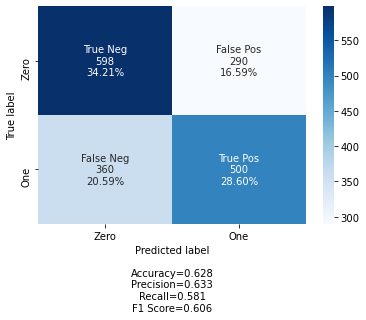

In [29]:
from cf_matrix import make_confusion_matrix
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(confusion_matrix(y_test, y_pred), 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [30]:
import matplotlib.pyplot as plt
def plot_roc(fpr, tpr, roc_auc):
    """Plots the ROC curve for the win probability model along with
    the AUC.
    """
    fig, ax = plt.subplots()
    ax.set(title='Receiver Operating Characteristic',
           xlim=[0, 1], ylim=[0, 1], xlabel='False Positive Rate',
           ylabel='True Positive Rate')
    ax.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.legend(loc='lower right')

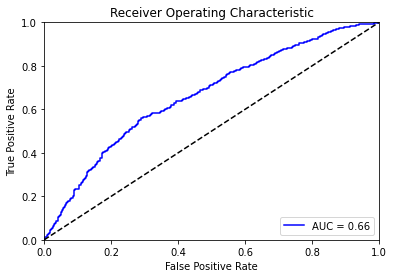

In [31]:
fpr, tpr, thresholds = roc_curve(y_test.values, y_prob[:,1])
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

In [32]:
import statsmodels.api as sm
smlogit = sm.Logit(y_train,X_train).fit()
smlogit.summary()

Optimization terminated successfully.
         Current function value: 0.670165
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                 6991
Model:                          Logit   Df Residuals:                     6982
Method:                           MLE   Df Model:                            8
Date:                Fri, 19 Mar 2021   Pseudo R-squ.:                 0.03314
Time:                        11:07:47   Log-Likelihood:                -4685.1
converged:                       True   LL-Null:                       -4845.7
Covariance Type:            nonrobust   LLR p-value:                 1.247e-64
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
prev_CW/SA_rate          4.2562      0.568      7.492      0.000       3.143       5.370
S_create2SA_Create       0.0008      0.007      0.107      0.915      -0.013       0.015
S_Create2Start_Time     -0.0009      0.007     -0.123      0.902      -0.015       0.013
SA_Create2Start_Time    -0.0008      0.007     -0.115      0.909      -0.015       0.013
U_create2now             0.0193      0.010      1.983      0.047       0.000       0.038
U_approve2now           -0.0473      0.011     -4.406      0.000      -0.068      -0.026
type_d                  -0.8080      0.089     -9.072      0.000      -0.983      -0.633
segmentName_d           -0.1355      0.074     -1.834      0.067      -0.280       0.009
net_pay                  0.0404      0.004      9.204      0.000       0.032       0.049
========================================================================================
"""

# Logistic Regression2, pick only significant vars

In [33]:
# sample non target = target

In [34]:
X = df4[['prev_CW/SA_rate', 'type_d', 'segmentName_d', 'net_pay', 'U_approve2now']]
Y = df4['target']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30)

In [35]:
logit = LogisticRegressionCV(scoring='roc_auc')
logit.fit(X_train,y_train)
y_pred= logit.predict(X_test)

In [36]:
smlogit = sm.Logit(y_train,X_train).fit()
smlogit.summary()

Optimization terminated successfully.
         Current function value: 0.677633
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                 6117
Model:                          Logit   Df Residuals:                     6112
Method:                           MLE   Df Model:                            4
Date:                Fri, 19 Mar 2021   Pseudo R-squ.:                 0.02230
Time:                        11:07:49   Log-Likelihood:                -4145.1
converged:                       True   LL-Null:                       -4239.6
Covariance Type:            nonrobust   LLR p-value:                 8.432e-40
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
prev_CW/SA_rate     3.6117      0.600      6.018      0.000       2.435       4.788
type_d             -0.7022      0.094     -7.489      0.000      -0.886      -0.518
segmentName_d      -0.1765      0.078     -2.253      0.024      -0.330      -0.023
net_pay             0.0334      0.004      7.462      0.000       0.025       0.042
U_approve2now      -0.0311      0.004     -8.626      0.000      -0.038      -0.024
===================================================================================
"""

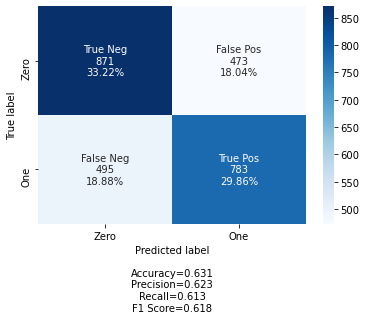

In [37]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(confusion_matrix(y_test, y_pred), 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [38]:
from sklearn.metrics import classification_report,confusion_matrix

#print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.64      0.65      0.64      1344
           1       0.62      0.61      0.62      1278

    accuracy                           0.63      2622
   macro avg       0.63      0.63      0.63      2622
weighted avg       0.63      0.63      0.63      2622



## Let's make the model face the reality: most people are not CW

In [39]:
df3 = df3[['prev_CW/SA_rate', 'type_d', 'segmentName_d', 'net_pay', 'U_approve2now','target']].dropna()
X_valid = df3[['prev_CW/SA_rate', 'type_d', 'segmentName_d', 'net_pay', 'U_approve2now']]
y_valid = df3['target']
# X_train, X_test, y_train, y_test = train_test_split(X_valid,Y_valid,test_size=0.3, random_state=42)

In [40]:
# logit = LogisticRegressionCV(scoring="roc_auc")
# logit.fit(X_train,y_train)
# #y_pred= logit.predict(X_test)

In [49]:
limiter = .80

y_prob = list(logit.predict_proba(X_valid)[:,1])
y_pred = []
count =0
for prob in y_prob:
    if prob >= limiter:
        y_pred.append(1)
        count+=1
    else:
        y_pred.append(0)
# count the ones who are marked as 1
print(count)

print(classification_report(y_valid, y_pred))

#scoring="f1"

2819
              precision    recall  f1-score   support

           0       0.97      0.98      0.98    163317
           1       0.05      0.03      0.04      4370

    accuracy                           0.96    167687
   macro avg       0.51      0.51      0.51    167687
weighted avg       0.95      0.96      0.95    167687



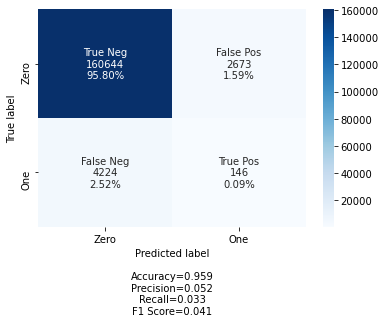

In [50]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(confusion_matrix(y_valid, y_pred), 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [43]:
from sklearn.metrics import (auc, classification_report, roc_auc_score, accuracy_score,
                             f1_score, log_loss, roc_curve, confusion_matrix, precision_score, 
                             recall_score,precision_recall_curve)
accuracy_score(y_valid, y_pred)

0.8399756689546596

In [ ]:
# def profit_calculation(model, x_value, y_value):
#     d_cutoff = 1/2

#     decision = list(model.predict_proba(x_value)[:,1] < d_cutoff)   
#     decision = list(model.predict(x_value))
#     y = list(y_value)
#     n_obs = len(y)

#     cum_profit = 0

#     for i in range(n_obs):
#         if decision[i] == True and y[i] == 1: 
#             profit = 0 
#         elif decision[i] == True and y[i] == 0: 
#             profit = 8 
#         elif decision[i] == False and y[i] == 1: 
#             profit = -2
#         else:
#             profit = 10 
#         cum_profit = cum_profit + profit 

#     average_net_profit = cum_profit / n_obs 
#     return average_net_profit